# 🧠 Text Preprocessing

## 📌 Project Overview
Text preprocessing is the essential first step in any NLP pipeline. It helps clean, normalize, and prepare raw text data for models — whether for traditional ML, deep learning, or LLMs.

In this notebook, we explore and compare several powerful text preprocessing techniques using:

- 🧰 NLTK
- ⚙️ SpaCy
- 🤗 Hugging Face Transformers

We will visualize, compare outputs, and analyze tradeoffs between these methods on real-world data.

## Imports

In [207]:
# Base Libraries
import nltk
import spacy
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# NLP
from nltk.corpus import twitter_samples

## Loading the data & Visualizing
We use NLTK’s `twitter_samples` dataset, which includes 10,000 tweets:
- 5,000 positive
- 5,000 negative

In [208]:
# Downloading the data
nltk.download('twitter_samples')
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')
nltk.download('wordnet') # English DB to figure out base forms of words
nltk.download('omw-1.4') #  for more accurate lemmatization, improves results

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [209]:
# Loading positive tweets separately
positive_tweets = twitter_samples.strings('positive_tweets.json')
# Loading negative tweets separately
negative_tweets = twitter_samples.strings('negative_tweets.json')

# Loading the Positive & Negative tweets
tweets = twitter_samples.strings('positive_tweets.json') + twitter_samples.strings('negative_tweets.json')

# Visualizing
print("Example of first tweet loaded:", tweets[0])
print("Total number of tweets:", len(tweets))
print("Total number of positive tweets:", len(positive_tweets))
print("Total number of negative tweets:", len(negative_tweets))
print("Type of 'tweets'", type(tweets))
print("Type of each tweet", type(tweets[0]))

Example of first tweet loaded: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Total number of tweets: 10000
Total number of positive tweets: 5000
Total number of negative tweets: 5000
Type of 'tweets' <class 'list'>
Type of each tweet <class 'str'>


### Visual Summary

- **Tweet Lengths**: Most tweets contain between **5 and 15 words**, as expected from short-form social media text.
- **Sentiment Classes**: There is an **equal distribution** of positive and negative tweets — 5,000 each — making it ideal for balanced comparison and preprocessing evaluation.


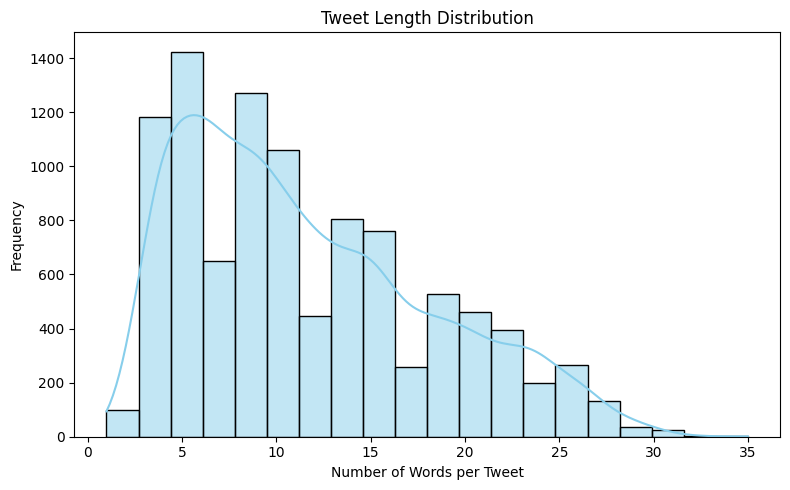

In [210]:
# Word count per tweet
tweet_lengths = [len(tweet.split()) for tweet in tweets]

plt.figure(figsize=(8, 5))
sns.histplot(tweet_lengths, bins=20, kde=True, color='skyblue')
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Words per Tweet")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


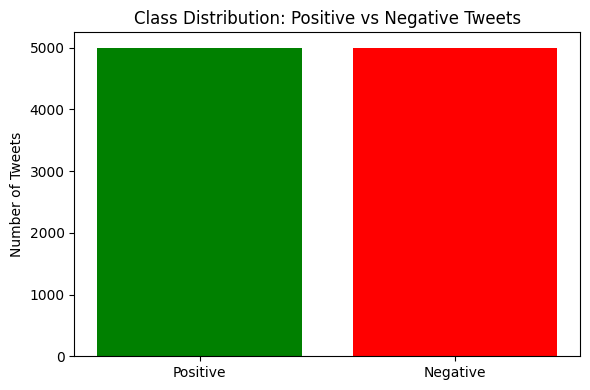

In [211]:
# Tweet counts
labels = ['Positive', 'Negative']
counts = [len(positive_tweets), len(negative_tweets)]

# Plot
plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['green', 'red'])
plt.title("Class Distribution: Positive vs Negative Tweets")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()

## Vocabulary Analysis

### Tokenizing using TweetTokenizer from NLTK
Before settling on TweetTokenizer, we tested `word_tokenize` and encountered dependency issues (punkt). 
Even after fixing them, we chose `TweetTokenizer` for its superior handling of hashtags, emojis, mentions, and informal spellings which are common in Twitter data.

In [212]:
from nltk.tokenize import TweetTokenizer

# we set preserve_case to true, to keep words with their punctuation
# strip_handles = false, to keep the mentions in the tweets as @France_Inte
# reduce_len = True, to reduce exaggerated words in case their is any (eg."Soo" => "So")
tokenizer = TweetTokenizer(preserve_case=True, strip_handles=False, reduce_len=True)

first_tweet = tweets[0]
tokenized_first_tweet = tokenizer.tokenize(first_tweet)

print("Tweet:", first_tweet)
print("Tokenized:", tokenized_first_tweet)

Tweet: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Tokenized: ['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


In [213]:
# Creating a list of all words in the tweets tokenized
all_tweet_tokens = [token for tweet in tweets for token in tokenizer.tokenize(tweet)]

print(len(all_tweet_tokens))

130055


In [214]:
# To calculate and see the count of occurrences of each token
from collections import Counter

token_freq = Counter(all_tweet_tokens)
print(token_freq.most_common(20))

[(':(', 4586), (':)', 3693), ('!', 2675), ('I', 2477), ('.', 2433), ('to', 2133), ('you', 2001), ('the', 1845), (',', 1698), ('a', 1515), ('and', 1274), ('(', 1262), ('?', 1225), ('for', 1140), ('my', 1113), ('it', 909), ('in', 902), ('is', 874), ('me', 854), ('i', 823)]


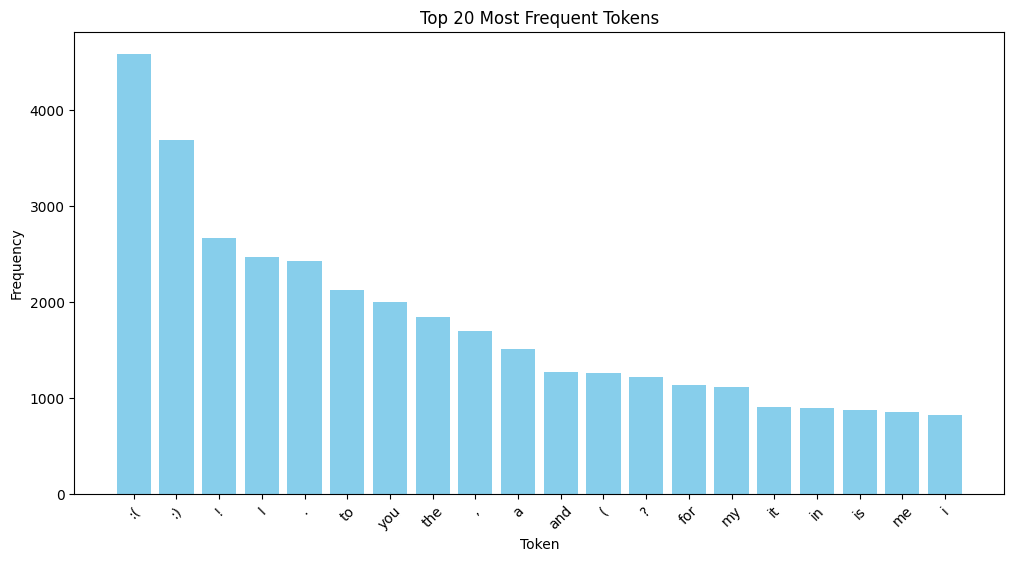

In [215]:
top_tokens = token_freq.most_common(20)
tokens, freqs = zip(*top_tokens)

plt.figure(figsize=(12,6))
plt.bar(tokens, freqs, color='skyblue')
plt.title("Top 20 Most Frequent Tokens")
plt.xticks(rotation=45)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.show()

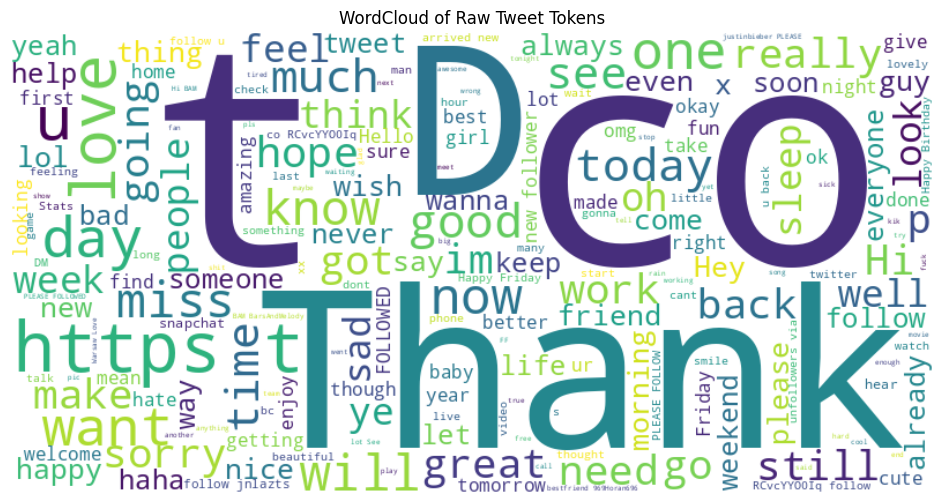

In [216]:
# Creating wordcloud for tokenized tweets 
from wordcloud import WordCloud

text_for_cloud = ' '.join(all_tweet_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_cloud)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Raw Tweet Tokens")
plt.show()


## 1) NLTK Preprocessing Pipeline: 
- Tokenizes tweets using `TweetTokenizer`
- Removes punctuation, numbers, and non-alphabetic tokens
- Removes English stopwords
- Lemmatizes tokens using `WordNetLemmatizer`

In [217]:
## 1) Tokenize
from nltk.tokenize import TweetTokenizer

tweet = tweets[0]
print("Original Tweet: \n", first_tweet)

# Our focus is the context of the tweet, so remoced strip handles, and focused on words themselves without preserving the case
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
tweet_tokens = tokenizer.tokenize(tweet)
print("Tokenized Tweet: \n", tweet_tokens)

Original Tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Tokenized Tweet: 
 ['#followfriday', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


In [218]:
# 2) Remove Punctuation and numbers 

# Remove Punctuation
# Find any character that is NOT a letter, number, underscore (\w), or whitespace (\s)
tweet_tokens_punct_removed = [re.sub(r'[^\w\s]', '', token) for token in tweet_tokens]
print("Tokenized Tweet without Punct: \n", tweet_tokens_punct_removed)

# Remove Numbers (if any), keeping only alpha characters
tweet_token_no_nums = [token for token in tweet_tokens_punct_removed if token.isalpha()]
print("Tokenized Tweet without Numbers: \n", tweet_token_no_nums)

Tokenized Tweet without Punct: 
 ['followfriday', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', '']
Tokenized Tweet without Numbers: 
 ['followfriday', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week']


In [219]:
# 3) Remove Stopwords 
from nltk.corpus import stopwords

# Getting the English Stopwords
stop_words = set(stopwords.words('english'))
print("Stopwords:", stop_words)
tweet_tokens_no_stopwords = [token for token in tweet_token_no_nums if token not in stop_words]
print("Tokenized Tweet without Stopwords: \n", tweet_tokens_no_stopwords)


Stopwords: {'again', 'theirs', 'above', "she'd", 'these', 'further', 'had', 'where', 'him', 'm', 'at', 'mustn', 'will', 'be', 'my', 'over', 'ain', 'am', "couldn't", "you'd", 'needn', 'were', 'doing', 'your', 'it', 'before', 'up', 're', 'has', 'this', 'o', "she'll", 'weren', 'but', 'been', 'under', 'couldn', "we've", 'to', "didn't", "shouldn't", 'that', 'his', 'hers', 'or', 'so', "he'd", 'what', 'wouldn', 'mightn', 'own', 'shan', "she's", 've', 'few', 'wasn', "hasn't", 'd', "wouldn't", "they've", 'during', 'out', "doesn't", "he'll", 'themselves', 'a', 'on', 'very', "needn't", "you'll", 'against', 'are', 'didn', 'then', 'most', 'we', 'some', 'after', 'in', 'our', 'once', 'about', 'their', 'there', 'ma', 'you', 'here', 'each', 'itself', 'off', "should've", 'such', 'do', "it'd", 'those', 'until', "we'll", 'he', "aren't", 'haven', "that'll", 'does', "mustn't", 'with', "it's", 'which', 'same', 'if', 'yourself', "he's", "we'd", 'ourselves', "shan't", "don't", 'only', 'whom', 'won', 'no', "you

### Stemming vs. Lemmatization 

For word normalization: we compare **stemming** (PorterStemmer) with **lemmatization** (WordNetLemmatizer).

- **Stemming** uses heuristic rules to chop word endings.
- **Lemmatization** uses a dictionary to return the proper base word.

While stemming is faster, it often returns incomplete or non-real words (e.g., `engag`, `commun`). Lemmatization is slower but more linguistically accurate.

In [220]:
# 4.1) Stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
tweet_tokens_stemmed = [stemmer.stem(token) for token in tweet_tokens_no_stopwords]
print("Stemmed Tweet: \n", tweet_tokens_stemmed)

# 4.2) Lemmatization
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
tweet_tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tweet_tokens_no_stopwords]
print("Lemmatized Tweet: \n", tweet_tokens_lemmatized)

Stemmed Tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week']
Lemmatized Tweet: 
 ['followfriday', 'top', 'engaged', 'member', 'community', 'week']


In [221]:
# NLTK Preprocessing function
def preprocess_nltk(text):
    # 1. Tokenize
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(text)

    # 2. Remove punctuation, numbers and non-alphabetic tokens
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
    tokens = [token for token in tokens if token.isalpha()]

    # 3. Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # 4. Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [222]:
# Testing
for i in range(5):
    print("Original:", tweets[i])
    print("Cleaned: ", preprocess_nltk(tweets[i]))
    print("-" * 50)

Original: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Cleaned:  ['followfriday', 'top', 'engaged', 'member', 'community', 'week']
--------------------------------------------------
Original: @Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!
Cleaned:  ['hey', 'james', 'odd', 'please', 'call', 'contact', 'centre', 'able', 'assist', 'many', 'thanks']
--------------------------------------------------
Original: @DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
Cleaned:  ['listen', 'last', 'night', 'bleed', 'amazing', 'track', 'scotland']
--------------------------------------------------
Original: @97sides CONGRATS :)
Cleaned:  ['congrats']
--------------------------------------------------
Original: yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profil

### Trying NLTK Preprocessing on Data

In [223]:
# Cleaning & Preprocessing first 1000 tweets using the nltk preprocessing function
preprocessed_tweets_nltk = [preprocess_nltk(tweet) for tweet in tweets[:1000]]

In [224]:
# Compare sizes of tokenized before and after preprocessing

# Tokenized tweets with no cleaning
original_tokens = [token for tweet in tweets[:1000] for token in tokenizer.tokenize(tweet)]

# Preprocessed tweets
cleaned_tokens = [token for tweet in preprocessed_tweets_nltk for token in tweet]

vocab_original = set(original_tokens)
vocab_cleaned = set(cleaned_tokens)

print("Original Vocab Size:", len(vocab_original))
print("After NLTK Cleaning Vocab Size:", len(vocab_cleaned))

Original Vocab Size: 2754
After NLTK Cleaning Vocab Size: 2126


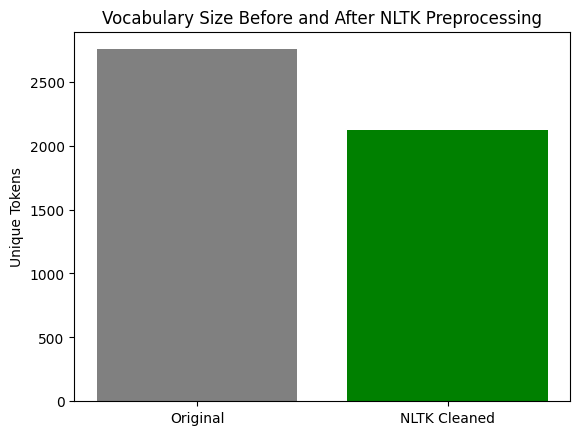

In [225]:
labels = ['Original', 'NLTK Cleaned']
sizes = [len(vocab_original), len(vocab_cleaned)]

plt.bar(labels, sizes, color=['gray', 'green'])
plt.title('Vocabulary Size Before and After NLTK Preprocessing')
plt.ylabel('Unique Tokens')
plt.show()

In [226]:
# Top 20 tokens after nltk preprocessing
token_freq_nltk_cleaned = Counter(cleaned_tokens)
print(token_freq_nltk_cleaned.most_common(20))

[('D', 135), ('follow', 117), ('u', 99), ('love', 70), ('thanks', 66), ('back', 55), ('day', 48), ('like', 46), ('hi', 46), ('thank', 43), ('good', 42), ('im', 37), ('great', 36), ('know', 35), ('new', 34), ('get', 33), ('week', 31), ('happy', 30), ('see', 30), ('hope', 29)]


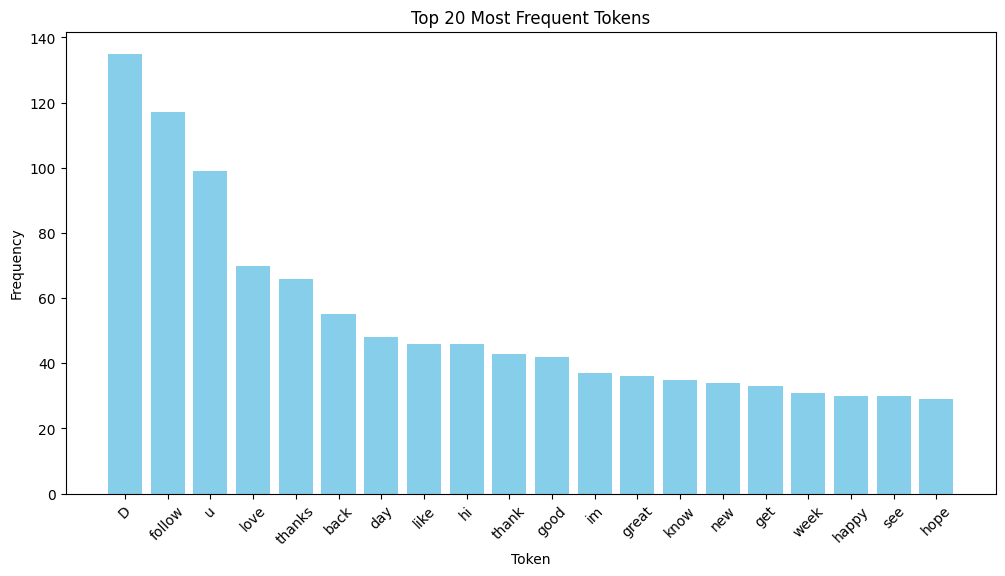

In [227]:
top_nltk_cleaned_tokens = token_freq_nltk_cleaned.most_common(20)
tokens_nltk, freqs_nltk = zip(*top_nltk_cleaned_tokens)

plt.figure(figsize=(12,6))
plt.bar(tokens_nltk, freqs_nltk, color='skyblue')
plt.title("Top 20 Most Frequent Tokens")
plt.xticks(rotation=45)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.show()

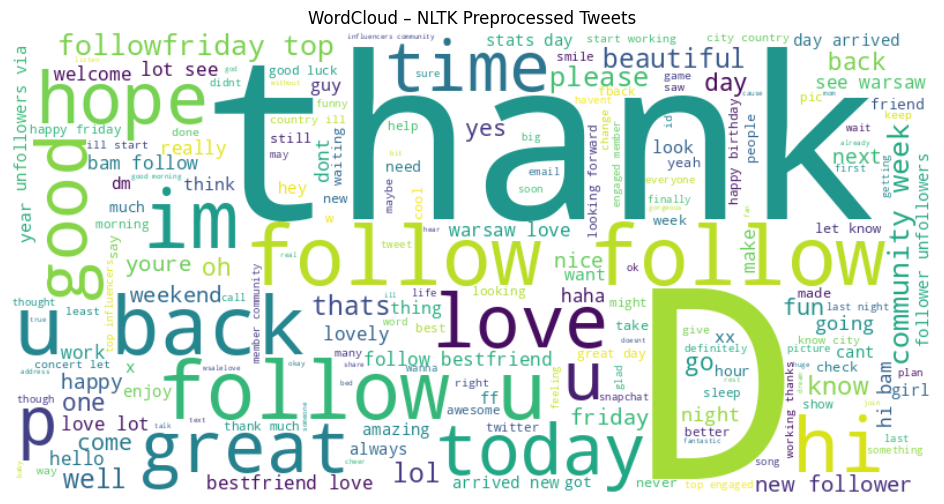

In [228]:
# Word Cloud for NLTK Preprocessed Tokens
all_nltk_cleaned_tokens = ' '.join(cleaned_tokens)
wordcloud_nltk = WordCloud(width=800, height=400, background_color='white').generate(all_nltk_cleaned_tokens)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_nltk, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud – NLTK Preprocessed Tweets")
plt.show()

## 2) SpaCy Preprocessing Pipeline:
We apply a custom SpaCy preprocessing function to:
- Tokenize the text
- Remove:
  - Stopwords 
  - Punctuation
  - Non-alphabetic tokens (e.g., numbers, emojis)
- Convert words to their **lemmatized** (base) form
- **Lowercase** all tokens for normalization

In [229]:
# 1) Process using SpaCy model
# Loading SpaCy's small English model
nlp = spacy.load("en_core_web_sm") 

tweet = tweets[0]
spacy_doc = nlp(tweet)

print("Original Tweet:", tweet)
print("SpaCy Tokens:", [token.text for token in spacy_doc])
print(type(spacy_doc))

Original Tweet: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
SpaCy Tokens: ['#', 'FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']
<class 'spacy.tokens.doc.Doc'>


In [230]:
# Identifying stopwords using is_stop
for token in spacy_doc:
    print(f"{token.text:15} | Is Stopword? → {token.is_stop}")

# Removing stopword 
tokens_spacy_no_stopwords = []
for token in spacy_doc:
    if not token.is_stop:
        tokens_spacy_no_stopwords.append(token)

print()
print("SpaCy Tokens:\n", [token.text for token in spacy_doc])
print("Tokens without stopwords:\n", tokens_spacy_no_stopwords)

#               | Is Stopword? → False
FollowFriday    | Is Stopword? → False
@France_Inte    | Is Stopword? → False
@PKuchly57      | Is Stopword? → False
@Milipol_Paris  | Is Stopword? → False
for             | Is Stopword? → True
being           | Is Stopword? → True
top             | Is Stopword? → True
engaged         | Is Stopword? → False
members         | Is Stopword? → False
in              | Is Stopword? → True
my              | Is Stopword? → True
community       | Is Stopword? → False
this            | Is Stopword? → True
week            | Is Stopword? → False
:)              | Is Stopword? → False

SpaCy Tokens:
 ['#', 'FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']
Tokens without stopwords:
 [#, FollowFriday, @France_Inte, @PKuchly57, @Milipol_Paris, engaged, members, community, week, :)]


In [231]:
# Removing Punctuation and allowing only alpha 
tokens_spacy_no_punctuation = []
for token in tokens_spacy_no_stopwords:
    if not token.is_punct and token.is_alpha:
        tokens_spacy_no_punctuation.append(token)

print()
print("SpaCy Tokens without stopwords:\n", [token for token in tokens_spacy_no_stopwords])
print("Tokens without Punctuation:\n", tokens_spacy_no_punctuation)


SpaCy Tokens without stopwords:
 [#, FollowFriday, @France_Inte, @PKuchly57, @Milipol_Paris, engaged, members, community, week, :)]
Tokens without Punctuation:
 [FollowFriday, engaged, members, community, week]


In [232]:
# Lemmatization
tokens_spacy_lemmatized = []
for token in tokens_spacy_no_punctuation:
        tokens_spacy_lemmatized.append(token.lemma_)

print()
print("SpaCy Tokens without Punctuation:\n", [token for token in tokens_spacy_no_punctuation])
print("Tokens Lemmatized:\n", tokens_spacy_lemmatized)


SpaCy Tokens without Punctuation:
 [FollowFriday, engaged, members, community, week]
Tokens Lemmatized:
 ['FollowFriday', 'engage', 'member', 'community', 'week']


In [233]:
# Final Spacy Preprocessing Function
def preprocess_spacy(text):
    doc = nlp(text)

    cleaned_tokens_spacy = []
    for token in doc: 
        if not token.is_stop and not token.is_punct and token.is_alpha:
            cleaned_tokens_spacy.append(token.lemma_.lower())

    return cleaned_tokens_spacy

In [234]:
for i in range(5):
    print("Original:", tweets[i])
    print("Cleaned: ", preprocess_spacy(tweets[i]))
    print("-" * 50)

Original: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Cleaned:  ['followfriday', 'engage', 'member', 'community', 'week']
--------------------------------------------------
Original: @Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!
Cleaned:  ['hey', 'james', 'odd', 'contact', 'centre', 'able', 'assist', 'thank']
--------------------------------------------------
Original: @DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
Cleaned:  ['listen', 'night', 'bleed', 'amazing', 'track', 'scotland']
--------------------------------------------------
Original: @97sides CONGRATS :)
Cleaned:  ['congrats']
--------------------------------------------------
Original: yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days
Cleaned:  ['yeaaaah', 'yipp

### Trying SpaCy Preprocessing on Data

In [235]:
# Cleaning & Preprocessing first 1000 tweets using the spacy preprocessing function
preprocessed_tweets_spacy = [preprocess_spacy(tweet) for tweet in tweets[:1000]]

In [236]:
# Compare sizes of tokenized before and after preprocessing

# Tokenized tweets with no cleaning
original_tokens = [token for tweet in tweets[:1000] for token in tokenizer.tokenize(tweet)]

# Preprocessed tweets
cleaned_tokens = [token for tweet in preprocessed_tweets_spacy for token in tweet]

vocab_original = set(original_tokens)
vocab_cleaned = set(cleaned_tokens)

print("Original Vocab Size:", len(vocab_original))
print("After NLTK Cleaning Vocab Size:", len(vocab_cleaned))

Original Vocab Size: 2754
After NLTK Cleaning Vocab Size: 1862


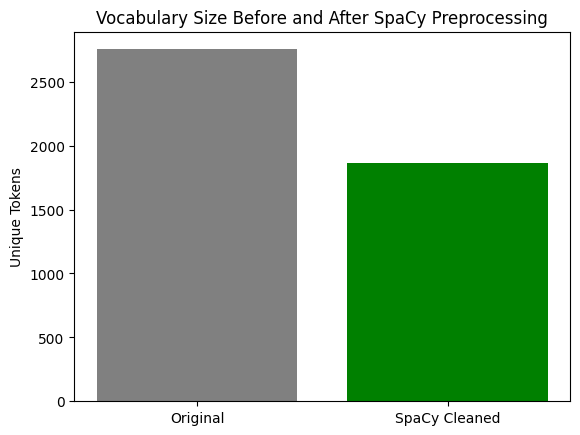

In [237]:
labels = ['Original', 'SpaCy Cleaned']
sizes = [len(vocab_original), len(vocab_cleaned)]

plt.bar(labels, sizes, color=['gray', 'green'])
plt.title('Vocabulary Size Before and After SpaCy Preprocessing')
plt.ylabel('Unique Tokens')
plt.show()

In [238]:
# Top 20 tokens after nltk preprocessing
token_freq_spacy_cleaned = Counter(cleaned_tokens)
print(token_freq_spacy_cleaned.most_common(20))

[('follow', 124), ('thank', 107), ('u', 76), ('love', 73), ('amp', 58), ('good', 49), ('like', 48), ('day', 46), ('hi', 46), ('know', 36), ('great', 36), ('new', 35), ('week', 31), ('happy', 30), ('hope', 29), ('today', 28), ('time', 27), ('look', 26), ('go', 25), ('community', 24)]


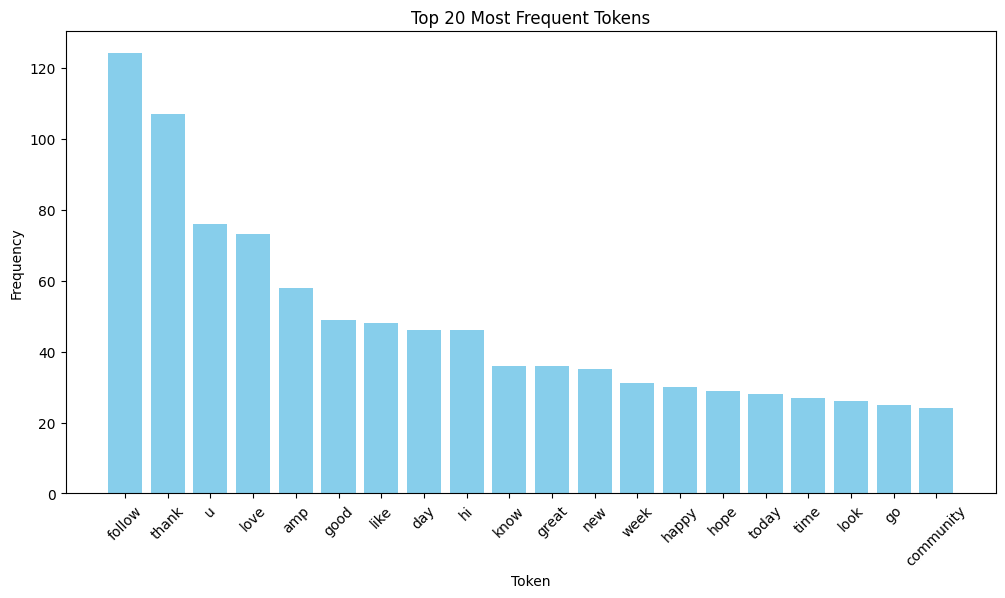

In [256]:
top_spacy_cleaned_tokens = token_freq_spacy_cleaned.most_common(20)
tokens_spacy, freqs_spacy = zip(*top_spacy_cleaned_tokens)

plt.figure(figsize=(12,6))
plt.bar(tokens_spacy, freqs_spacy, color='skyblue')
plt.title("Top 20 Most Frequent Tokens")
plt.xticks(rotation=45)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.show()

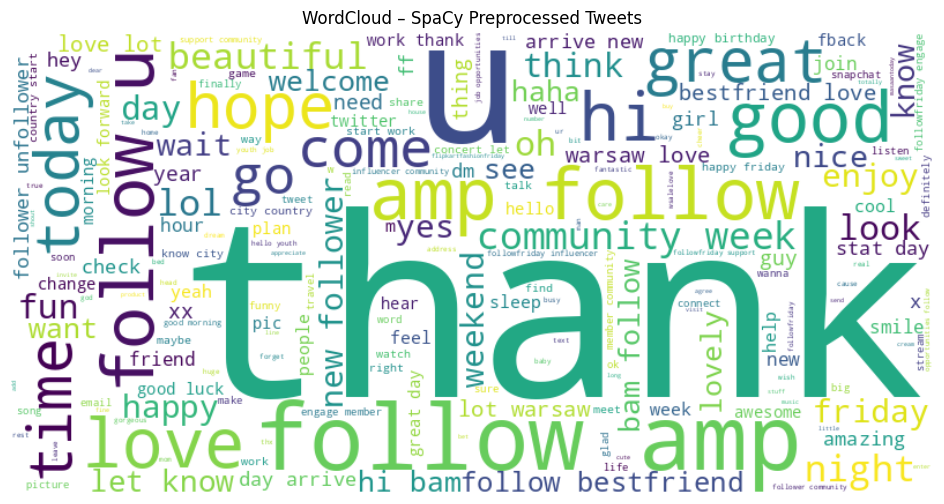

In [257]:
# Word Cloud for Spacy Preprocessed Tokens
all_spacy_cleaned_tokens = ' '.join(cleaned_tokens)
wordcloud_spacy = WordCloud(width=800, height=400, background_color='white').generate(all_spacy_cleaned_tokens)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_spacy, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud – SpaCy Preprocessed Tweets")
plt.show()

## 3) Hugging Face Preprocessing
We’ll use the **BERT-base-uncased** tokenizer:
- Automatically lowercases input
- Splits words into **subword units** (e.g. `##ing`, `##ly`, etc.)
- Retains important structure like mentions, hashtags, punctuation

Unlike NLTK and SpaCy, we don’t manually remove stopwords or punctuation — Hugging Face tokenizers are designed to leave text as-is, to match how their models were originally trained. Pre-trained transformers like BERT require the exact tokenizer used during training. So we do not clean the text manually for Hugging Face models.

In [241]:
from transformers import AutoTokenizer

# Load tokenizer for BERT base
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [242]:
tweet = tweets[0]
print("Original Tweet:\n", tweet)

tokenized_hg_tweet = tokenizer.tokenize(tweet)
print("Tokenized Hugging Face Tweet:\n", tokenized_hg_tweet)

Original Tweet:
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Tokenized Hugging Face Tweet:
 ['#', 'follow', '##frid', '##ay', '@', 'france', '_', 'int', '##e', '@', 'p', '##ku', '##ch', '##ly', '##57', '@', 'mil', '##ip', '##ol', '_', 'paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':', ')']


In [243]:
tokenized_hg_all = [tokenizer.tokenize(tweet) for tweet in tweets[:1000]]

In [244]:
# Compare sizes of tokenized before and after preprocessing
# Flattening
from itertools import chain

# Tokenized tweets with no cleaning
original_tokens = [token for tweet in tweets[:1000] for token in tokenizer.tokenize(tweet)]

# Tokenized tweets with hugging face
all_hg_tokens = list(chain.from_iterable(tokenized_hg_all))

vocab_original = set(original_tokens)
vocab_hg = set(all_hg_tokens)

print("Original Vocab Size:", len(vocab_original))
print("Vocabulary Size (Hugging Face):", len(vocab_hg))

Original Vocab Size: 4197
Vocabulary Size (Hugging Face): 4197


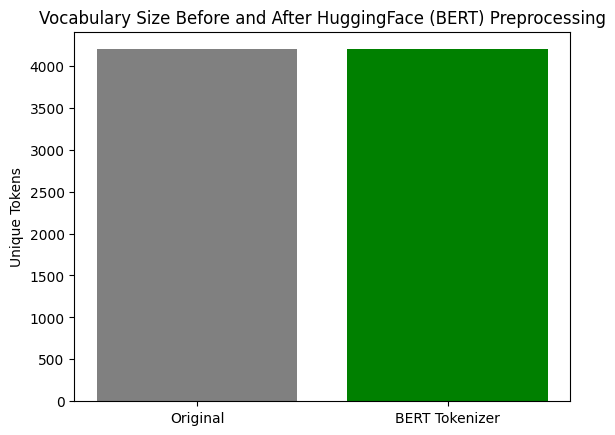

In [245]:
labels = ['Original', 'BERT Tokenizer']
sizes = [len(vocab_original), len(vocab_hg)]

plt.bar(labels, sizes, color=['gray', 'green'])
plt.title('Vocabulary Size Before and After HuggingFace (BERT) Preprocessing')
plt.ylabel('Unique Tokens')
plt.show()

In [246]:
# Top 20 tokens after hg preprocessing
token_freq_hf_cleaned = Counter(all_hg_tokens)
print(token_freq_hf_cleaned.most_common(20))

[(':', 1337), ('@', 1130), (')', 1055), ('/', 787), ('.', 765), ('!', 360), ('t', 324), ('you', 321), ('i', 267), ('co', 259), ('#', 248), ("'", 233), ('to', 211), ('the', 205), ('-', 198), ('_', 196), ('http', 185), ('a', 184), (',', 183), ('d', 161)]


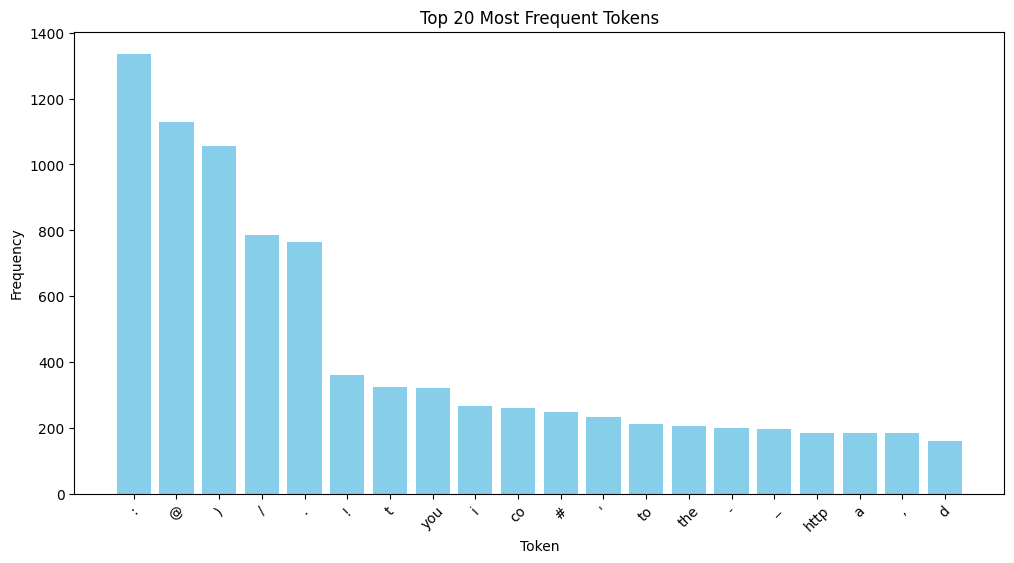

In [247]:
top_hf_cleaned_tokens = token_freq_hf_cleaned.most_common(20)
tokens, freqs = zip(*top_hf_cleaned_tokens)

plt.figure(figsize=(12,6))
plt.bar(tokens, freqs, color='skyblue')
plt.title("Top 20 Most Frequent Tokens")
plt.xticks(rotation=45)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.show()

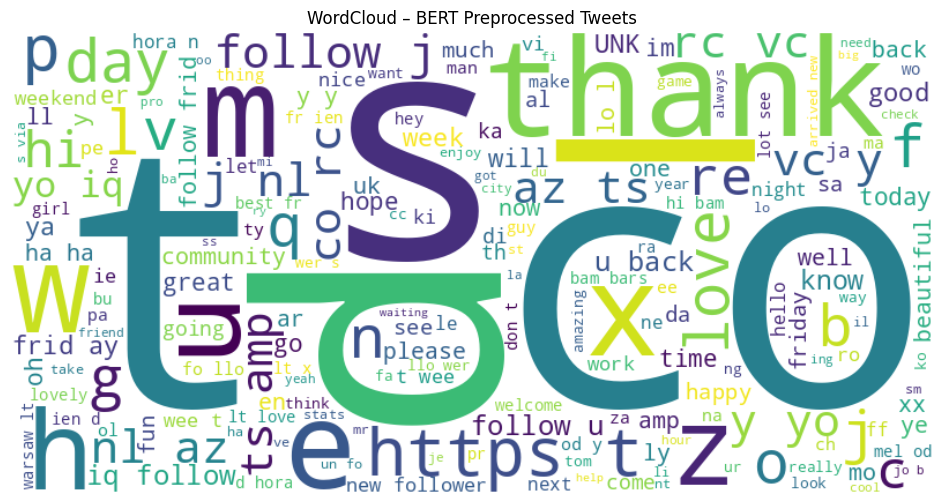

In [248]:
# Word Cloud for Hf Preprocessed Tokens
all_hf_cleaned_tokens = ' '.join(all_hg_tokens)
wordcloud_hf = WordCloud(width=800, height=400, background_color='white').generate(all_hf_cleaned_tokens)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_hf, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud – BERT Preprocessed Tweets")
plt.show()

## Comparison

### Vocabulary Size

We compare how each preprocessing method affects the overall vocabulary size on the first 1,000 tweets:

- **Original**: Raw tokens without cleaning.
- **NLTK**: Applies punctuation/stopword removal and lemmatization.
- **SpaCy**: Uses rules for stopword removal and lemmatization.
- **Hugging Face**: Uses subword tokenization (WordPiece) with the BERT Tokenizer with no cleaning.


In [249]:
# Original Vocab (before preprocessing)
vocab_original = set(token for tweet in tweets[:1000] for token in tokenizer.tokenize(tweet))

# NLTK Vocab Size
vocab_nltk = set(token for tweet in preprocessed_tweets_nltk for token in tweet)

# SpaCy Vocab Size
vocab_spacy = set(token for tweet in preprocessed_tweets_spacy for token in tweet)

# Hugging Face Vocab Size
vocab_hf = set(all_hg_tokens)

print("Vocabulary Size: \n--------------------")
print("Original Vocab:", len(vocab_original))
print("NLTK Vocab:", len(vocab_nltk))
print("Spacy Vocab:", len(vocab_spacy))
print("HF Vocab:", len(vocab_hf))

Vocabulary Size: 
--------------------
Original Vocab: 4197
NLTK Vocab: 2126
Spacy Vocab: 1862
HF Vocab: 4197


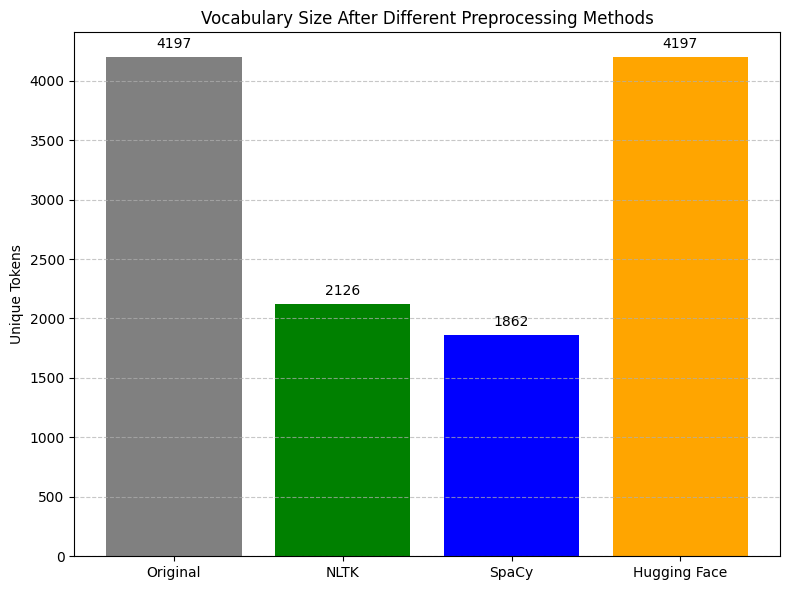

In [250]:
# Bar Chart Comparison
labels = ['Original', 'NLTK', 'SpaCy', 'Hugging Face']
sizes = [len(vocab_original), len(vocab_nltk), len(vocab_spacy), len(vocab_hf)]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, sizes, color=['gray', 'green', 'blue', 'orange'])
plt.title('Vocabulary Size After Different Preprocessing Methods')
plt.ylabel('Unique Tokens')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{yval}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [251]:
# NLTK
top_tokens_nltk = Counter(token for tweet in preprocessed_tweets_nltk for token in tweet).most_common(20)

# SpaCy
top_tokens_spacy = Counter(token for tweet in preprocessed_tweets_spacy for token in tweet).most_common(20)

# Hugging Face
top_tokens_hf = Counter(all_hg_tokens).most_common(20)

In [252]:
# Creating DataFrame
top_df = pd.DataFrame({
    'NLTK': [token for token, _ in top_tokens_nltk],
    'SpaCy': [token for token, _ in top_tokens_spacy],
    'Hugging Face': [token for token, _ in top_tokens_hf]
})

top_df.index = [f'#{i+1}' for i in range(20)]
display(top_df)


,NLTK,SpaCy,Hugging Face
#1,D,follow,:
#2,follow,thank,@
#3,u,u,)
#4,love,love,/
#5,thanks,amp,.
#6,back,good,!
#7,day,like,t
#8,like,day,you
#9,hi,hi,i
#10,thank,know,co


### Vocabulary Simplification Score

In [258]:
simplified_nltk = len(vocab_nltk) / len(vocab_original)
simplified_spacy = len(vocab_spacy) / len(vocab_original)
simplified_hf = len(vocab_hf) / len(vocab_original)

print("Vocabulary Compression Ratios:")
print(f"NLTK: {simplified_nltk:.2f} ({len(vocab_nltk)} / {len(vocab_original)})")
print(f"SpaCy: {simplified_spacy:.2f} ({len(vocab_spacy)} / {len(vocab_original)})")
print(f"Hugging Face: {simplified_hf:.2f} ({len(vocab_hf)} / {len(vocab_original)})")

Vocabulary Compression Ratios:
NLTK: 0.51 (2126 / 4197)
SpaCy: 0.44 (1862 / 4197)
Hugging Face: 1.00 (4197 / 4197)


### Output Comparison

In [253]:
sample_tweets = tweets[:3]

comparison_data = {
    'Original Tweet': sample_tweets,
    'NLTK': [' '.join(preprocess_nltk(tweet)) for tweet in sample_tweets],
    'SpaCy': [' '.join(preprocess_spacy(tweet)) for tweet in sample_tweets],
    'Hugging Face': [' '.join(tokenizer.tokenize(tweet)) for tweet in sample_tweets],
}

comparison_df = pd.DataFrame(comparison_data)
pd.set_option('display.max_colwidth', None)
comparison_df.index = [f'Tweet #{i+1}' for i in range(3)]
comparison_df.T


,Tweet #1,Tweet #2,Tweet #3
Original Tweet,#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :),@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!,@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
NLTK,followfriday top engaged member community week,hey james odd please call contact centre able assist many thanks,listen last night bleed amazing track scotland
SpaCy,followfriday engage member community week,hey james odd contact centre able assist thank,listen night bleed amazing track scotland
Hugging Face,# follow ##frid ##ay @ france _ int ##e @ p ##ku ##ch ##ly ##57 @ mil ##ip ##ol _ paris for being top engaged members in my community this week : ),@ lamb ##2 ##ja hey james ! how odd : / please call our contact centre on 02 ##39 ##24 ##41 ##23 ##4 and we will be able to assist you : ) many thanks !,@ despite ##off ##icia ##l we had a listen last night : ) as you bleed is an amazing track . when are you in scotland ? !


- **NLTK** and **SpaCy** greatly simplify the text, which is useful for traditional models (e.g., logistic regression, SVM).
  - They remove stopwords, punctuation, mentions, and emojis.
  - They reduce the vocabulary via lemmatization.
  - SpaCy is more linguistically aware than NLTK.
  
- **Hugging Face (BERT)** tokenizer does *not* simplify or clean text.
  - It preserves everything: mentions, hashtags, emojis, numbers.
  - It breaks words into subwords for better generalization (e.g., `##official`, `##frid`).
  - This is **intentional**: BERT was trained on such tokenized input.

### Preprocessing Methods – Pros & Cons

| Method        | Pros                                         | Cons                                         | Best Use Case                        |
|---------------|----------------------------------------------|----------------------------------------------|--------------------------------------|
| **NLTK**      | Fast, customizable, removes noise well       | Can be overly aggressive, lacks context      | Traditional ML pipelines             |
| **SpaCy**     | Linguistically aware, accurate lemmatization | Slower, larger memory footprint              | Deep learning pipelines              |
| **Hugging Face** | Preserves model structure, subword-aware | Doesn’t remove noise, larger vocab size      | Transformers (BERT, GPT, etc.)       |


Use NLTK/SpaCy when we need to clean raw text.  
Use Hugging Face tokenizer *as-is* when feeding models like BERT/GPT — do **not** manually clean first.